# Sessa Empirical Estimator

This notebook implements the Sessa Empirical Estimator to analyze event intervals and compare the clustering results of **K-Means** and **DBSCAN**.

### Objectives
1. **Preprocessing:** Calculate event intervals and filter outliers (top 20%).
2. **Clustering Algorithms**
   - K-Means: Optimizes the number of clusters using silhouette scores.
   - DBSCAN: Identifies density-based clusters and noise points.
3. **Comparison:** Highlight differences in performance, cluster shapes, and noise handling between the two methods.

### Instructions
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.

_Each step has been encapsulated into **callable functions** as per the given additional task._

---

## Implementation

### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

### 2. Load and preprocess data

In [2]:
def load_and_preprocess(filepath):
    data = pd.read_csv(filepath)
    data.columns = ["PATIENT_ID", "DATE", "PERDAY", "CATEGORY", "DURATION"]
    data["DATE"] = pd.to_datetime(data["DATE"])

    data = data.sort_values(by=["PATIENT_ID", "DATE"])
    data["PREV_DATE"] = data.groupby("PATIENT_ID")["DATE"].shift(1)
    data = data.dropna(subset=["PREV_DATE"])
    data["EVENT_INTERVAL"] = (data["DATE"] - data["PREV_DATE"]).dt.days
    data = data[data["EVENT_INTERVAL"] > 0]

    return data

filepath = "med_events.csv"
med_events = load_and_preprocess(filepath)

med_events.head()

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION,PREV_DATE,EVENT_INTERVAL
1,1,2033-07-04,4,medB,30,2033-04-26,69
2,1,2033-08-03,4,medB,30,2033-07-04,30
3,1,2033-08-17,4,medB,30,2033-08-03,14
4,1,2033-10-13,4,medB,30,2033-08-17,57
5,1,2033-10-16,4,medB,30,2033-10-13,3


### 3. ECDF

In [3]:
def compute_ecdf(data):
    sorted_data = np.sort(data)
    ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ecdf_y

### 4. K-Means clustering

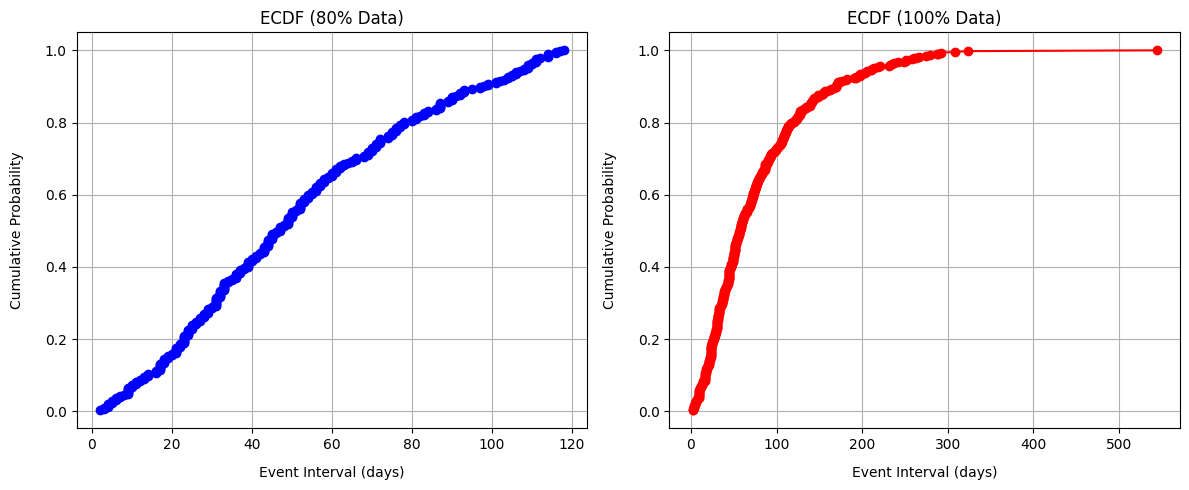

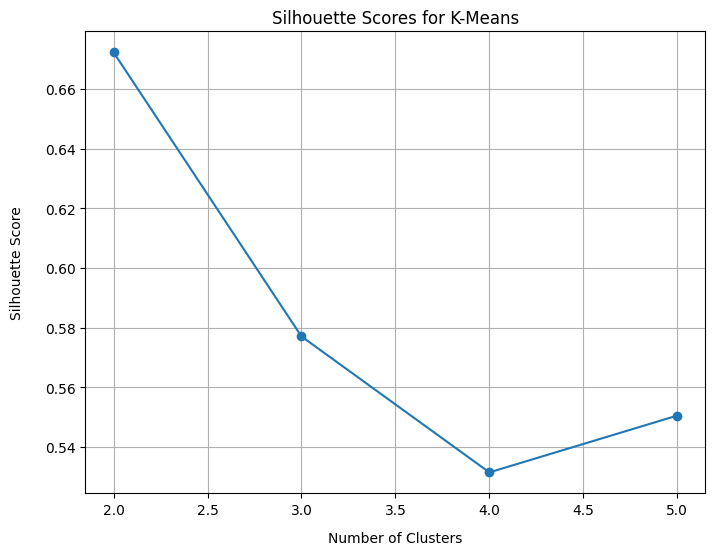

Optimal number of clusters: 2


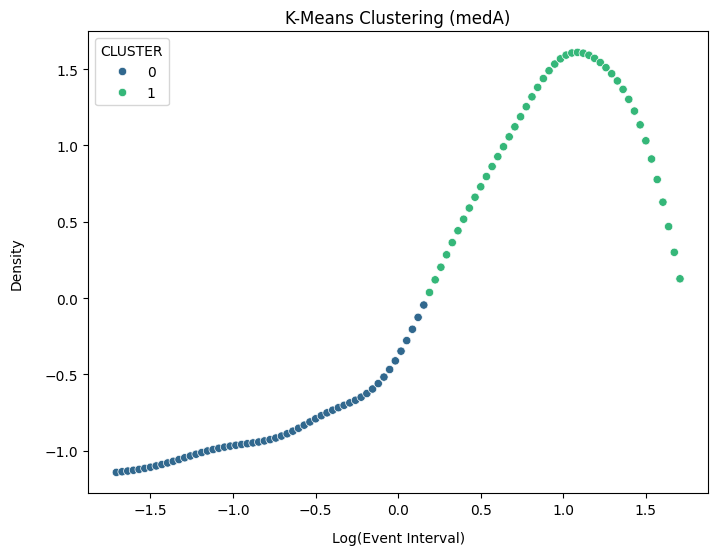

In [4]:
def see_kmeans(data, category, max_clusters=5):
    subset = data[data["CATEGORY"] == category].copy()
    if subset.empty:
        print(f"No data available for category {category}.")
        return pd.DataFrame()

    # compute event intervals and filter top 20%
    subset = subset.sort_values(by=["PATIENT_ID", "DATE"])
    sorted_intervals = np.sort(subset["EVENT_INTERVAL"])
    cutoff = np.percentile(sorted_intervals, 80)
    subset_80 = subset[subset["EVENT_INTERVAL"] <= cutoff]

    if subset_80.empty:
        print(f"No valid data after filtering for category {category}.")
        return pd.DataFrame()

    # compute ECDF
    x_80, y_80 = compute_ecdf(subset_80["EVENT_INTERVAL"])
    x_full, y_full = compute_ecdf(sorted_intervals)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_80, y_80, marker="o", linestyle="-", color="blue", label="80% Data")
    plt.title("ECDF (80% Data)")
    plt.xlabel("Event Interval (days)", labelpad=10)
    plt.ylabel("Cumulative Probability", labelpad=15)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(x_full, y_full, marker="o", linestyle="-", color="red", label="100% Data")
    plt.title("ECDF (100% Data)")
    plt.xlabel("Event Interval (days)", labelpad=10)
    plt.ylabel("Cumulative Probability", labelpad=15)
    plt.grid()
    plt.tight_layout()
    plt.show()

    log_intervals = np.log(subset_80["EVENT_INTERVAL"])
    density = gaussian_kde(log_intervals)
    x_vals = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_vals = density(x_vals)
    clustering_data = pd.DataFrame({"x": x_vals, "y": y_vals})
    clustering_data = (clustering_data - clustering_data.mean()) / clustering_data.std()

    # optimize K-Means clustering
    silhouette_scores = []
    best_k = 2
    best_score = -1
    for k in range(2, min(max_clusters, len(clustering_data)) + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(clustering_data)
        score = silhouette_score(clustering_data, kmeans.labels_)
        silhouette_scores.append(score)
        if score > best_score:
            best_k = k
            best_score = score

    plt.figure(figsize=(8, 6))
    plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker="o")
    plt.title("Silhouette Scores for K-Means")
    plt.xlabel("Number of Clusters", labelpad=10)
    plt.ylabel("Silhouette Score", labelpad=15)
    plt.grid()
    plt.show()

    print(f"Optimal number of clusters: {best_k}")

    # final K-Means clustering
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    clustering_data["CLUSTER"] = kmeans.fit_predict(clustering_data)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="x", y="y", hue="CLUSTER", data=clustering_data, palette="viridis")
    plt.title(f"K-Means Clustering ({category})")
    plt.xlabel("Log(Event Interval)", labelpad=10)
    plt.ylabel("Density", labelpad=15)
    plt.show()

    return clustering_data

category = "medA"
kmeans_results = see_kmeans(med_events, category)

### 5. DBSCAN clustering

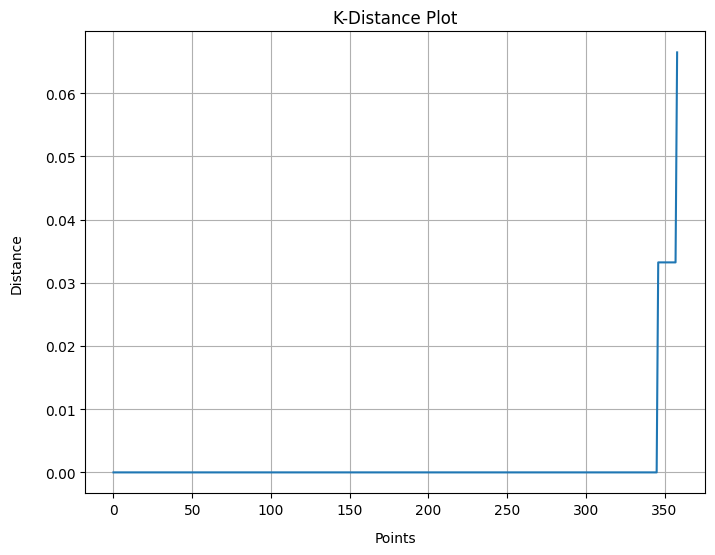

Selected epsilon: 0.1


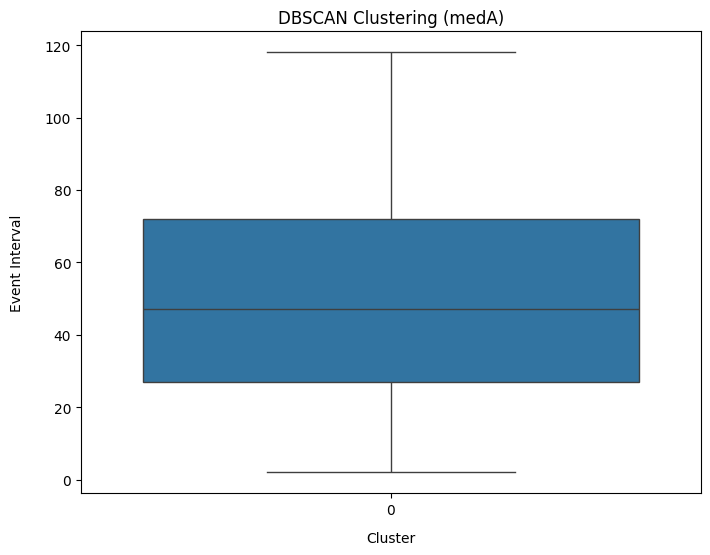

In [5]:
def see_dbscan(data, category):
    subset = data[data["CATEGORY"] == category].copy()
    if subset.empty:
        print(f"No data available for category {category}.")
        return pd.DataFrame()

    # compute event intervals and filter top 20%
    subset = subset.sort_values(by=["PATIENT_ID", "DATE"])
    sorted_intervals = np.sort(subset["EVENT_INTERVAL"])
    cutoff = np.percentile(sorted_intervals, 80)
    subset_80 = subset[subset["EVENT_INTERVAL"] <= cutoff].copy()

    if subset_80.empty:
        print(f"No valid data after filtering for category {category}.")
        return pd.DataFrame()

    # normalize the intervals
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(subset_80["EVENT_INTERVAL"].values.reshape(-1, 1))

    # determine optimal epsilon using k-distance
    neighbors = NearestNeighbors(n_neighbors=2).fit(scaled_data)
    distances, _ = neighbors.kneighbors(scaled_data)
    sorted_distances = np.sort(distances[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(sorted_distances)
    plt.title("K-Distance Plot")
    plt.xlabel("Points", labelpad=10)
    plt.ylabel("Distance", labelpad=15)
    plt.grid()
    plt.show()

    # choose eps as the knee point with a minimum threshold
    eps_value = max(np.percentile(sorted_distances, 90), 0.1)
    print(f"Selected epsilon: {eps_value}")

    # DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    subset_80["CLUSTER"] = dbscan.fit_predict(scaled_data)

    # treat noise as NaN
    subset_80["CLUSTER"] = subset_80["CLUSTER"].replace(-1, np.nan)

    plt.figure(figsize=(8, 6))
    sns.boxplot(x="CLUSTER", y="EVENT_INTERVAL", data=subset_80)
    plt.title(f"DBSCAN Clustering ({category})")
    plt.xlabel("Cluster", labelpad=10)
    plt.ylabel("Event Interval", labelpad=15)
    plt.show()

    return subset_80

dbscan_results = see_dbscan(med_events, category)

### 6. Results comparison

In [6]:
print("K-Means Clustering Results:")
print(kmeans_results.head())

print("\nDBSCAN Clustering Results:")
print(dbscan_results.head())

K-Means Clustering Results:
          x         y  CLUSTER
0 -1.706220 -1.141172        0
1 -1.671751 -1.136989        0
2 -1.637282 -1.132417        0
3 -1.602813 -1.127312        0
4 -1.568344 -1.121524        0

DBSCAN Clustering Results:
    PATIENT_ID       DATE  PERDAY CATEGORY  DURATION  PREV_DATE  \
25           2 2036-03-10       4     medA        50 2036-01-20   
63           4 2033-08-30       4     medA        50 2033-08-20   
64           4 2033-12-17       4     medA        50 2033-08-30   
67           5 2031-12-27       8     medA        30 2031-10-26   
68           5 2032-01-25       8     medA        30 2031-12-27   

    EVENT_INTERVAL  CLUSTER  
25              50        0  
63              10        0  
64             109        0  
67              62        0  
68              29        0  


---

## Insights and Comparison

### 1. K-Means Clustering
- K-Means clustering provides structured clusters and ensures every point is assigned to a cluster but struggles with noise and assumes spherical cluster shapes, potentially blending outliers into clusters.

### 2. DBSCAN Clustering
- DBSCAN identifies noise points and adapts to arbitrary cluster shapes, but it has limitations wherein the results depend on the choice of eps and min_samples which can be dataset-specific.

### 3. Key Comparisons
- Cluster Shapes: K-Means assumes fixed shapes, while DBSCAN handles irregular clusters.
- Noise Handling: DBSCAN explicitly marks outliers as noise, offering better insight into data anomalies.
- Practical Implications: The choice of method depends on the dataset's characteristics and the analytical goals (e.g., general patterns vs. anomaly detection).

The comparison highlights that DBSCAN provides a nuanced view of the data, particularly for identifying noise and irregular patterns, while K-Means offers a straightforward and structured clustering approach.